In [19]:
cd /home/dmoi/projects/foldtree2/

/home/dmoi/projects/foldtree2


In [20]:
import sys
sys.path.append('/home/dmoi/projects/foldtree2')
#read the afdb clusters file
import pandas as pd
import numpy as np
import glob
import os
#autoreload
import pickle
from src import AFDB_tools
import toytree
import tqdm
from matplotlib import pyplot as plt
import torch
from converter import pdbgraph
converter = pdbgraph.PDB2PyG()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [21]:
modelname = 'newmodelmk5'
modeldir = './models/'

with open( modeldir + modelname + '.pkl', 'rb') as f:
	encoder, decoder = pickle.load(f)

encoder.eval()
decoder.eval()	
encoder.to(device)
decoder.to(device)

HeteroGAE_Decoder(
  (convs): ModuleList(
    (0-3): 4 x HeteroConv(num_relations=3)
  )
  (norms): ModuleList(
    (0-3): 4 x LayerNorm((20,), eps=1e-05, elementwise_affine=True)
  )
  (bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm_in): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (bn_foldx): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm_foldx): LayerNorm((23,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.001, inplace=False)
  (jk): JumpingKnowledge(cat)
  (sigmoid): Sigmoid()
  (lin): Sequential(
    (0): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=80, out_features=20, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): GELU(approximate='none')
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): GELU(approximate='none')
    (7): Linear(in_features=20, ou

In [22]:
from torch_geometric.data import DataLoader , HeteroData

struct_dat = pdbgraph.StructureDataset('structalignmk4.h5')
#struct_dat = ft2.StructureDataset('structs_training.h5')
encoder_loader = DataLoader(struct_dat, batch_size=1, shuffle=True)
#encode the structures
encode_alns = True
if encode_alns == True:
	def databatch2list(loader , limit = 10):
		for i,data in enumerate(loader):
			if i > limit:
				break
			data = data.to_data_list()
			for d in data:
				d = d.to(device)
				yield d
	encoder_loader = databatch2list(encoder_loader)
	encoder.encode_structures_fasta(encoder_loader , modeldir + modelname+'_aln_encoded_test.fasta' )

/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
11it [00:00, 17.10it/s]


In [23]:
encoded_fasta =  modeldir + modelname+'_aln_encoded_test.fasta' 
seqstr = ''
ID = ''
seqdict = {}
with open(encoded_fasta, 'r') as f:
	#read all chars of file into a string
	for line in tqdm.tqdm(f):
		if line[0] == '>' and line[-1] == '\n':
			seqdict[ID] = seqstr
			ID = line[1:].strip()
			seqstr = ''
		else:
			seqstr += line.strip()
del seqdict['']
encoded_df = pd.DataFrame( seqdict.items() , columns=['protid', 'seq'] )
#change index to protid
encoded_df.index = encoded_df.protid
encoded_df = encoded_df.drop( 'protid', axis=1 )

encoded_df['ord'] = encoded_df.seq.map( lambda x: [ ord(c) for c in x] )
#hex starts at 1
encoded_df['hex2'] = encoded_df.ord.map( lambda x: [ hex(c) for c in x] )

22it [00:00, 64302.92it/s]


In [24]:
charset = 249
#make fasta is shifted by 1 and goes from 1-248 included
#0x01 – 0xFF excluding > (0x3E), = (0x3D), < (0x3C), - (0x2D), Space (0x20), Carriage Return (0x0d) and Line Feed (0x0a)
#replace 0x22 or " which is necesary for nexus files and 0x23 or # which is also necesary

replace_dict = {chr(0):chr(246) , '"':chr(248) , '#':chr(247), '>' : chr(249), '=' : chr(250), '<' : chr(251), '-' : chr(252), ' ' : chr(253) , '\r' : chr(254), '\n' : chr(255) }
rev_replace_dict = { v:k for k,v in replace_dict.items() }

replace_dict_ord = { ord(k):ord(v) for k,v in replace_dict.items() }
rev_replace_dict_ord = { ord(v):ord(k) for k,v in replace_dict.items() }

print(replace_dict)
print(rev_replace_dict)

print( replace_dict_ord )

print(rev_replace_dict_ord)

{'\x00': 'ö', '"': 'ø', '#': '÷', '>': 'ù', '=': 'ú', '<': 'û', '-': 'ü', ' ': 'ý', '\r': 'þ', '\n': 'ÿ'}
{'ö': '\x00', 'ø': '"', '÷': '#', 'ù': '>', 'ú': '=', 'û': '<', 'ü': '-', 'ý': ' ', 'þ': '\r', 'ÿ': '\n'}
{0: 246, 34: 248, 35: 247, 62: 249, 61: 250, 60: 251, 45: 252, 32: 253, 13: 254, 10: 255}
{246: 0, 248: 34, 247: 35, 249: 62, 250: 61, 251: 60, 252: 45, 253: 32, 254: 13, 255: 10}


In [25]:
encoded_df.seq = encoded_df.seq.map(lambda x : ''.join([ c if c not in replace_dict else replace_dict[c] for c in x]))
print(encoded_df)

                                                          seq  \
protid                                                          
A0A388Q399  ...   
A0A6H5JUE2  ...   
D2J7K3      ...   
A0A373PZY1  ...   
J3NWF1      ...   
A0A6A3CLM8  ...   
A0A448XFY4  ...   
U6HA94      ...   
I1PA27      ...   
A0A645EF50  ...   

                                                          ord  \
protid                                                          
A0A388Q399  [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...   
A0A6H5JUE2  [20, 20, 20,

In [26]:
import py3Dmol

def view_custom_pdb(pdb_file, chain='A'):
	"""
	Visualize a PDB structure from a file, highlight a specific residue with thicker sticks,
	show the backbone for the selected residue, and add an arrow-like indicator.
	
	Parameters:
	- pdb_file: str, path to the local PDB file.
	- residue_num: int, residue number to highlight.
	- chain: str, the chain identifier (default 'A').
	"""
	# Read the PDB file content
	with open(pdb_file, 'r') as f:
		pdb_content = f.read()

	# Initialize py3Dmol viewer
	viewer = py3Dmol.view(width=800, height=600)
	
	# Add the PDB structure to the viewer
	viewer.addModel(pdb_content, 'pdb')
	
	# Apply cartoon style for the overall structure
	viewer.setStyle({'cartoon': {'color': 'cyan'}})
	
	
	# Add molecular surface for the rest of the structure
	viewer.addSurface(py3Dmol.VDW, {'opacity': 0.5})
	
	
	# Set zoom and background color
	viewer.zoomTo()
	viewer.setBackgroundColor('white')
	
	# Show the structure
	return viewer.show()



A0A388Q399


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

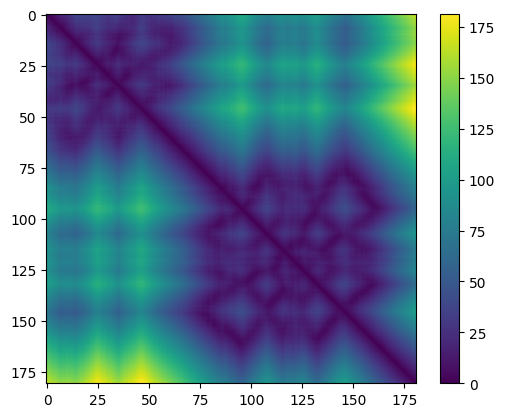

181
torch.Size([181, 100])
HeteroData(
  res={
    x=[181, 100],
    batch=[181],
  },
  positions={ x=[181, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 180] },
  (res, backbone_rev, res)={ edge_index=[2, 180] },
  (godnode4decoder, informs, res)={ edge_index=[2, 181] },
  (res, informs, godnode4decoder)={ edge_index=[2, 181] },
  (res, informs, godnode)={ edge_index=[2, 181] }
)
torch.Size([32761])
tensor([[-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        ...,
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[0.7311, 0.7311, 0.7311,  ..., 0.7311, 0

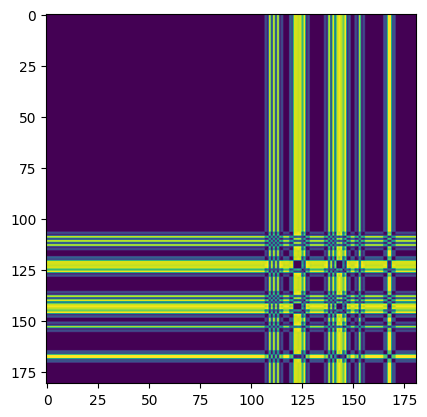

torch.Size([181, 181])
(181, 181)


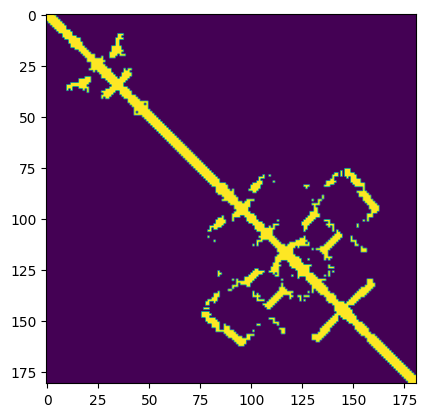

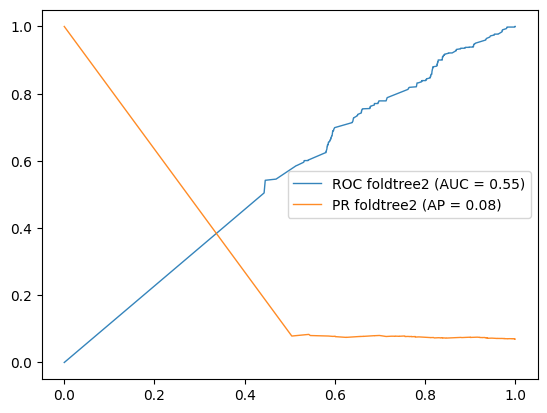

A0A6H5JUE2


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

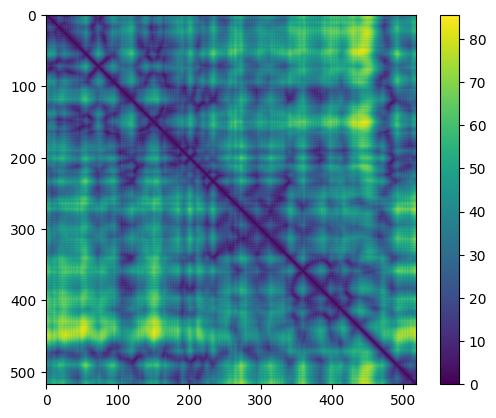

518
torch.Size([518, 100])
HeteroData(
  res={
    x=[518, 100],
    batch=[518],
  },
  positions={ x=[518, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 517] },
  (res, backbone_rev, res)={ edge_index=[2, 517] },
  (godnode4decoder, informs, res)={ edge_index=[2, 518] },
  (res, informs, godnode4decoder)={ edge_index=[2, 518] },
  (res, informs, godnode)={ edge_index=[2, 518] }
)
torch.Size([268324])
tensor([[-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        ...,
        [-1.8528, -3.0530, -3.3309,  ..., -4.1994, -3.5844, -2.8772],
        [-2.2799, -2.8541, -3.3249,  ..., -4.1953, -3.6330, -2.8305],
        [-3.9089, -2.5893, -3.0219,  ..., -4.4472, -3.6301, -2.7144]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[0.7311, 0.7311, 0.7311,  ..., 0.5208, 

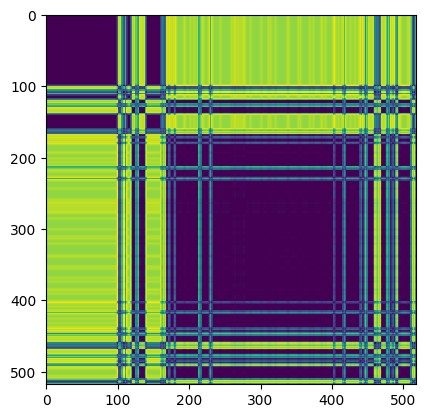

torch.Size([518, 518])
(518, 518)


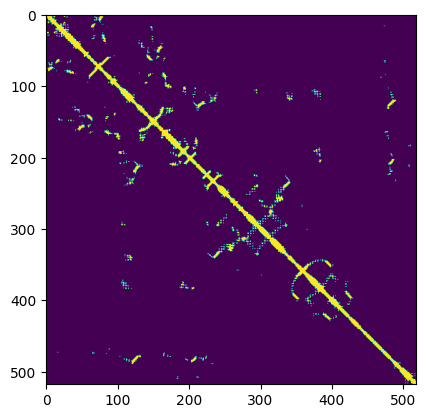

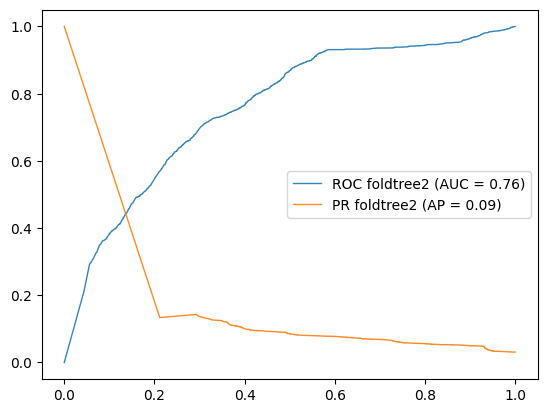

D2J7K3


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

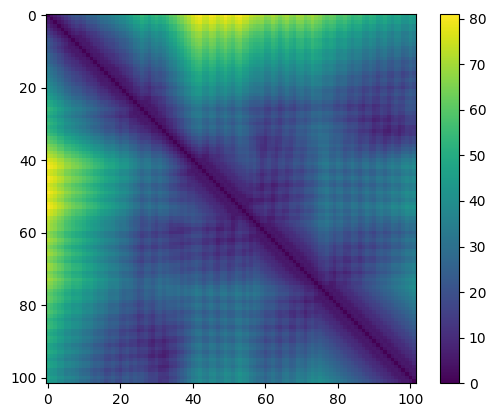

102
torch.Size([102, 100])
HeteroData(
  res={
    x=[102, 100],
    batch=[102],
  },
  positions={ x=[102, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 101] },
  (res, backbone_rev, res)={ edge_index=[2, 101] },
  (godnode4decoder, informs, res)={ edge_index=[2, 102] },
  (res, informs, godnode4decoder)={ edge_index=[2, 102] },
  (res, informs, godnode)={ edge_index=[2, 102] }
)
torch.Size([10404])
tensor([[-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        ...,
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[0.7311, 0.7311, 0.7311,  ..., 0.7311, 0

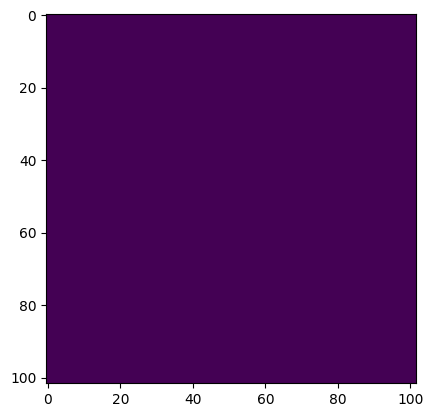

torch.Size([102, 102])
(102, 102)


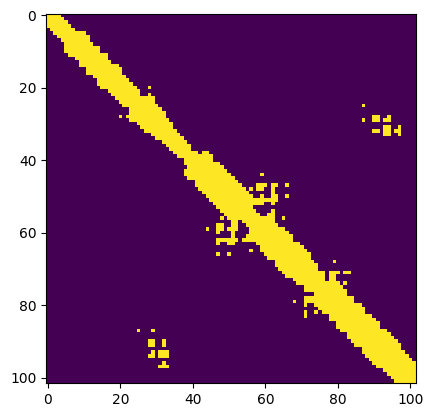

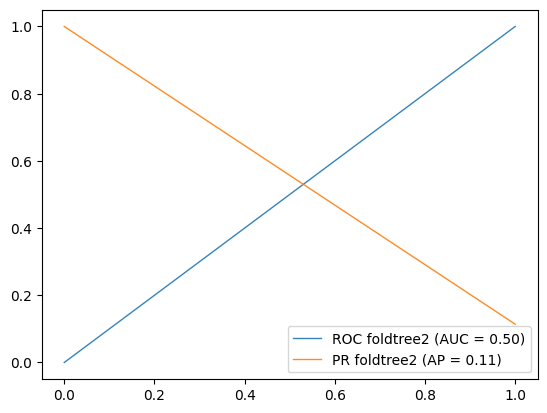

A0A373PZY1


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

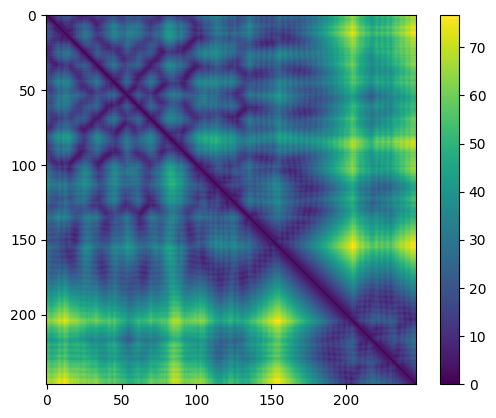

247
torch.Size([247, 100])
HeteroData(
  res={
    x=[247, 100],
    batch=[247],
  },
  positions={ x=[247, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 246] },
  (res, backbone_rev, res)={ edge_index=[2, 246] },
  (godnode4decoder, informs, res)={ edge_index=[2, 247] },
  (res, informs, godnode4decoder)={ edge_index=[2, 247] },
  (res, informs, godnode)={ edge_index=[2, 247] }
)
torch.Size([61009])
tensor([[-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        ...,
        [-3.8973, -2.5997, -3.0143,  ..., -4.4273, -3.6043, -2.7099],
        [-3.8974, -2.5997, -3.0144,  ..., -4.4273, -3.6043, -2.7099],
        [-3.8974, -2.5997, -3.0144,  ..., -4.4273, -3.6043, -2.7099]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[0.7311, 0.7311, 0.7311,  ..., 0.3487, 0

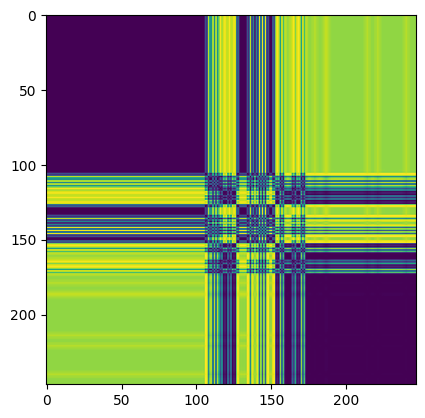

torch.Size([247, 247])
(247, 247)


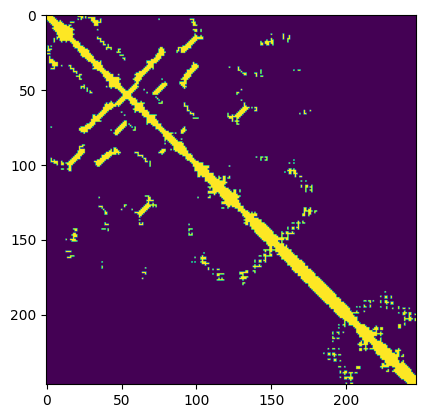

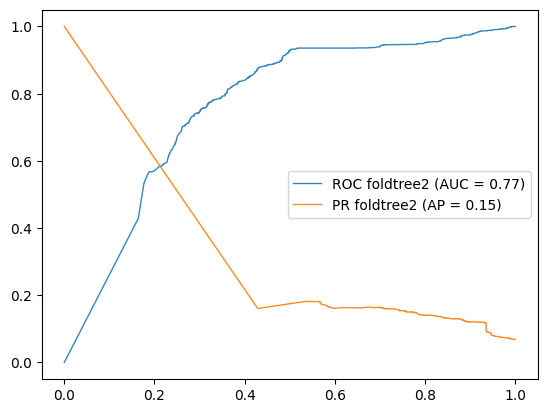

J3NWF1


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

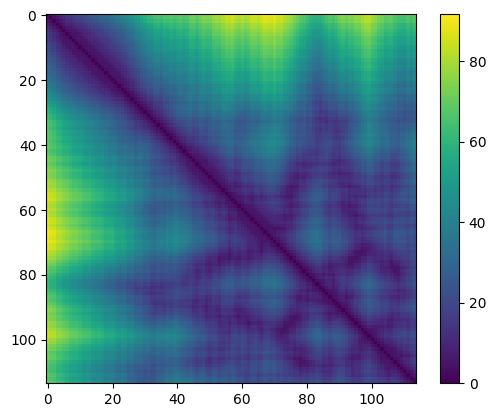

114
torch.Size([114, 100])
HeteroData(
  res={
    x=[114, 100],
    batch=[114],
  },
  positions={ x=[114, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 113] },
  (res, backbone_rev, res)={ edge_index=[2, 113] },
  (godnode4decoder, informs, res)={ edge_index=[2, 114] },
  (res, informs, godnode4decoder)={ edge_index=[2, 114] },
  (res, informs, godnode)={ edge_index=[2, 114] }
)
torch.Size([12996])
tensor([[-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        ...,
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[0.7311, 0.7311, 0.7311,  ..., 0.7311, 0

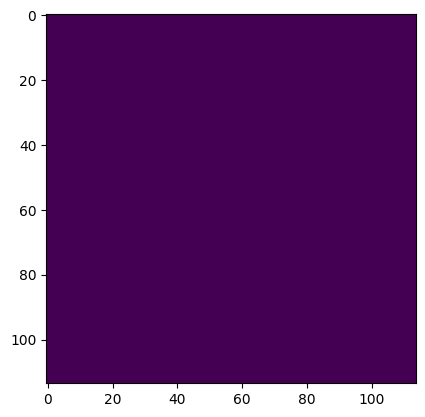

torch.Size([114, 114])
(114, 114)


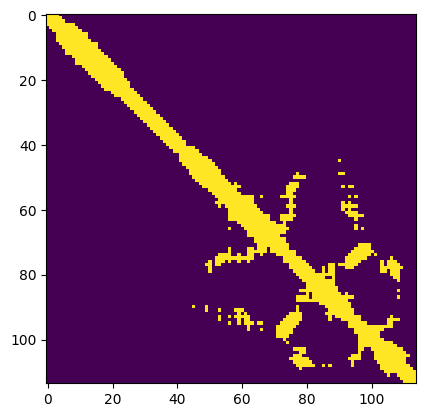

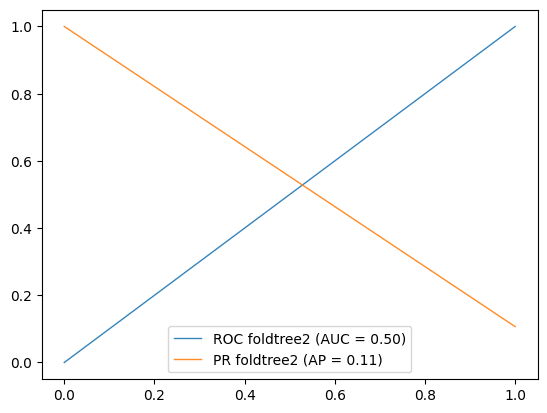

A0A6A3CLM8


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

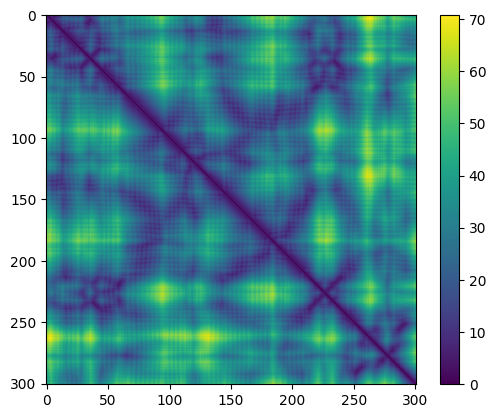

301
torch.Size([301, 100])
HeteroData(
  res={
    x=[301, 100],
    batch=[301],
  },
  positions={ x=[301, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 300] },
  (res, backbone_rev, res)={ edge_index=[2, 300] },
  (godnode4decoder, informs, res)={ edge_index=[2, 301] },
  (res, informs, godnode4decoder)={ edge_index=[2, 301] },
  (res, informs, godnode)={ edge_index=[2, 301] }
)
torch.Size([90601])
tensor([[-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        ...,
        [-1.8874, -3.0351, -3.3300,  ..., -4.1965, -3.5888, -2.8713],
        [-3.8928, -2.5970, -3.0086,  ..., -4.4252, -3.6036, -2.7119],
        [-3.8931, -2.5946, -3.0081,  ..., -4.4275, -3.6069, -2.7130]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[0.7311, 0.7311, 0.7311,  ..., 0.5326, 0

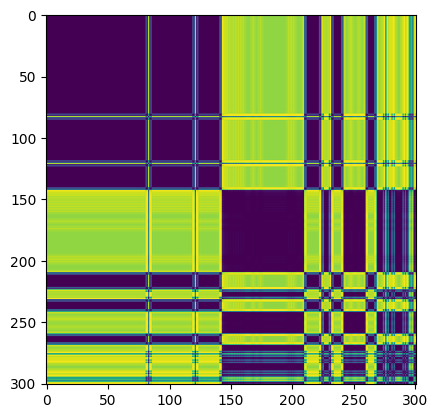

torch.Size([301, 301])
(301, 301)


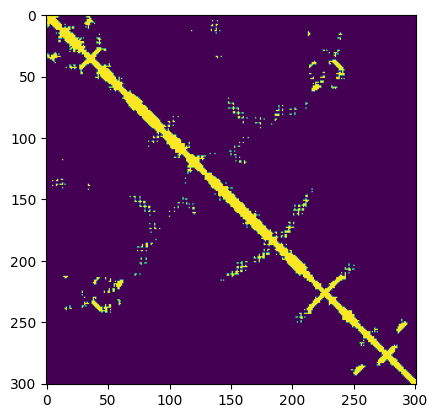

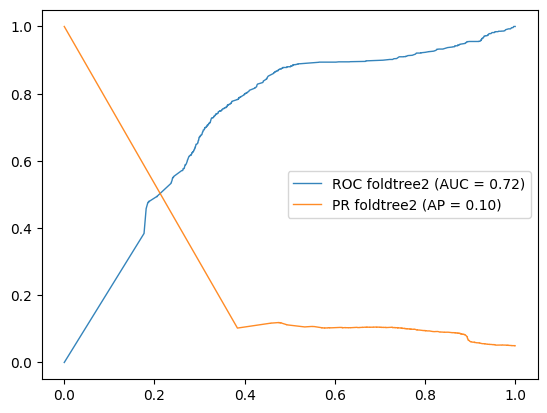

A0A448XFY4


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

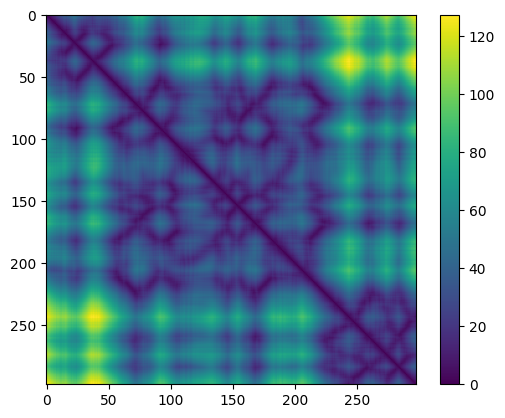

298
torch.Size([298, 100])
HeteroData(
  res={
    x=[298, 100],
    batch=[298],
  },
  positions={ x=[298, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 297] },
  (res, backbone_rev, res)={ edge_index=[2, 297] },
  (godnode4decoder, informs, res)={ edge_index=[2, 298] },
  (res, informs, godnode4decoder)={ edge_index=[2, 298] },
  (res, informs, godnode)={ edge_index=[2, 298] }
)
torch.Size([88804])
tensor([[-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        ...,
        [-3.8957, -2.5991, -3.0122,  ..., -4.4264, -3.6036, -2.7105],
        [-3.8963, -2.5991, -3.0129,  ..., -4.4269, -3.6040, -2.7104],
        [-3.8972, -2.5997, -3.0142,  ..., -4.4272, -3.6043, -2.7100]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[0.7311, 0.7311, 0.7311,  ..., 0.3342, 0

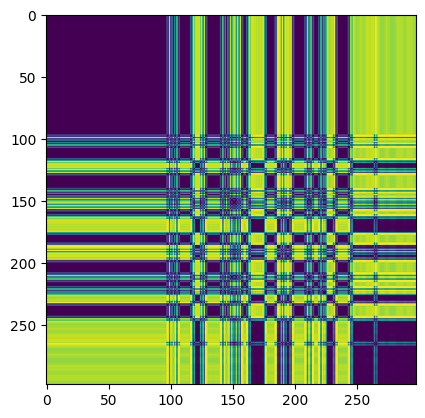

torch.Size([298, 298])
(298, 298)


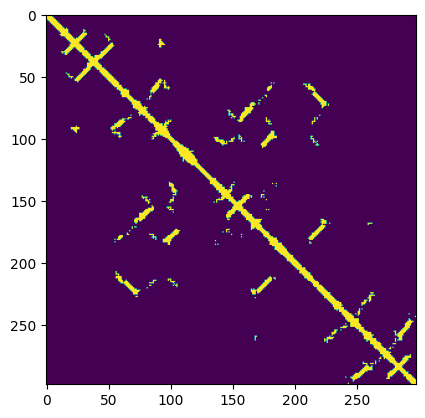

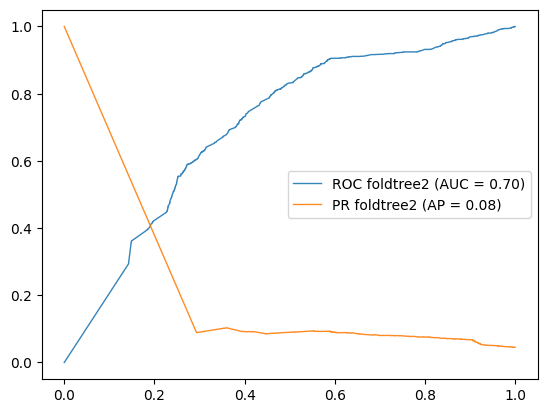

U6HA94


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

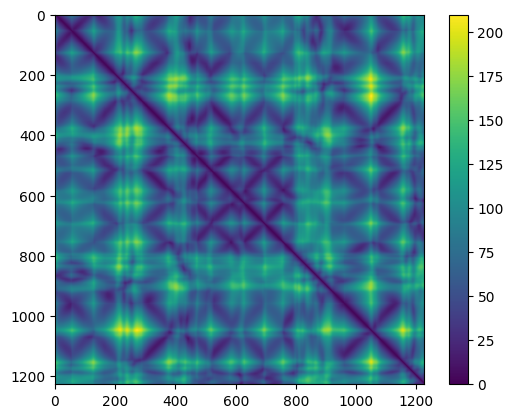

1227
torch.Size([1227, 100])
HeteroData(
  res={
    x=[1227, 100],
    batch=[1227],
  },
  positions={ x=[1227, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 1226] },
  (res, backbone_rev, res)={ edge_index=[2, 1226] },
  (godnode4decoder, informs, res)={ edge_index=[2, 1227] },
  (res, informs, godnode4decoder)={ edge_index=[2, 1227] },
  (res, informs, godnode)={ edge_index=[2, 1227] }
)
torch.Size([1505529])
tensor([[-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        ...,
        [-3.8935, -2.5969, -3.0092,  ..., -4.4260, -3.6040, -2.7118],
        [-3.8953, -2.5989, -3.0118,  ..., -4.4262, -3.6035, -2.7107],
        [-1.2789, -3.3585, -3.3401,  ..., -4.3858, -3.5148, -3.1073]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[0.7311, 0.7311, 0.7311,  ..

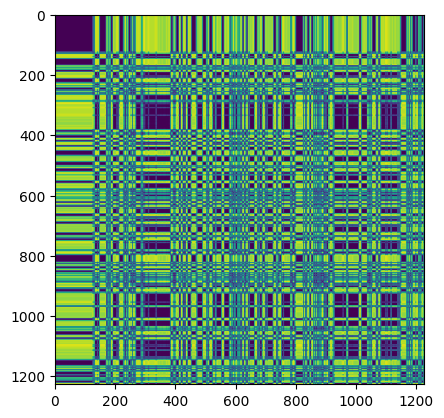

torch.Size([1227, 1227])
(1227, 1227)


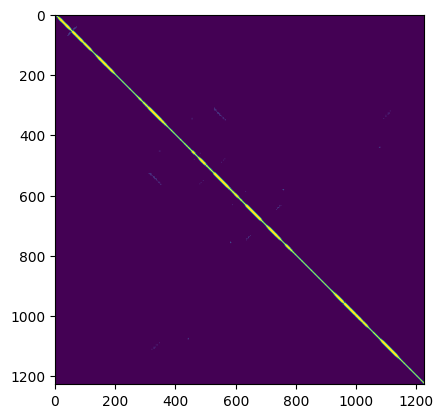

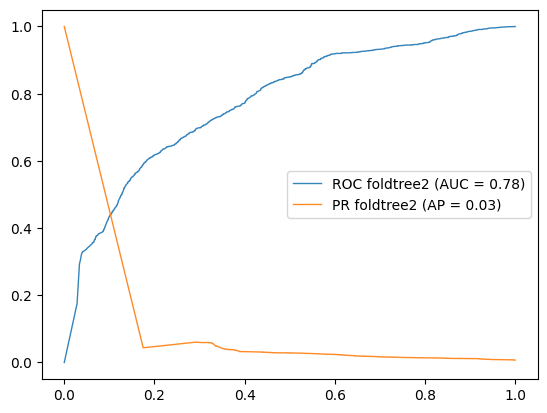

I1PA27


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

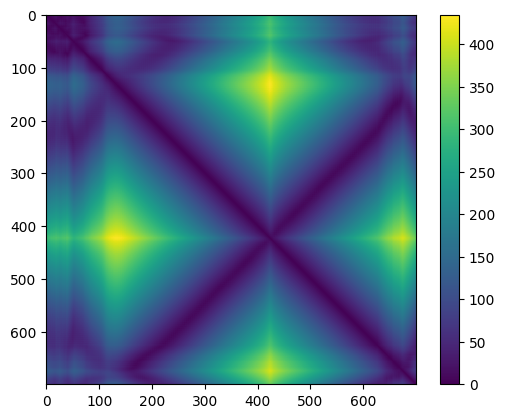

700
torch.Size([700, 100])
HeteroData(
  res={
    x=[700, 100],
    batch=[700],
  },
  positions={ x=[700, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 699] },
  (res, backbone_rev, res)={ edge_index=[2, 699] },
  (godnode4decoder, informs, res)={ edge_index=[2, 700] },
  (res, informs, godnode4decoder)={ edge_index=[2, 700] },
  (res, informs, godnode)={ edge_index=[2, 700] }
)
torch.Size([490000])
tensor([[-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        ...,
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[0.7311, 0.7311, 0.7311,  ..., 0.7311, 

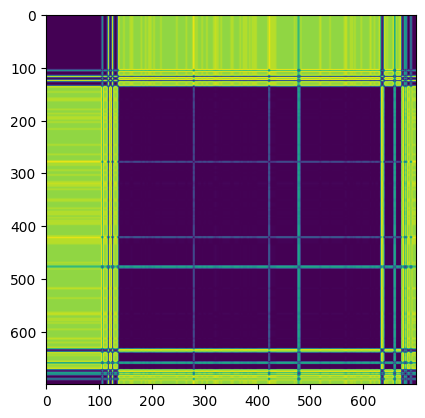

torch.Size([700, 700])
(700, 700)


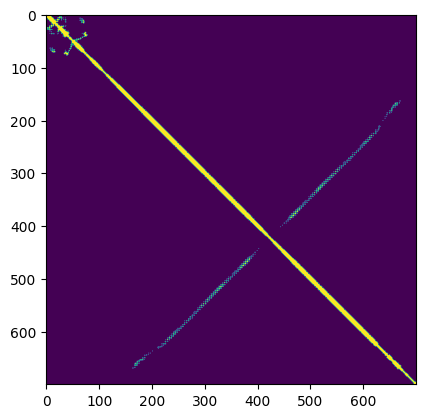

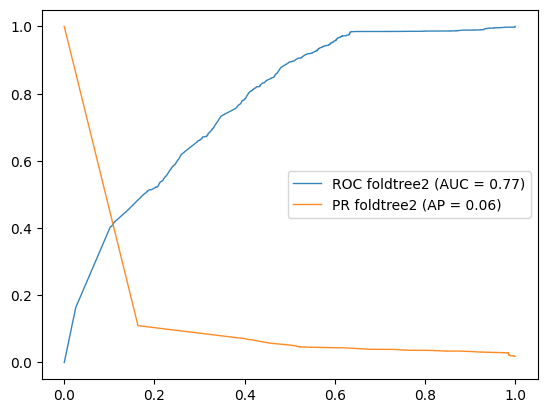

A0A645EF50


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

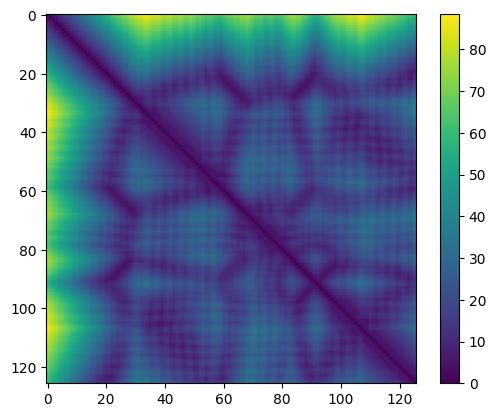

126
torch.Size([126, 100])
HeteroData(
  res={
    x=[126, 100],
    batch=[126],
  },
  positions={ x=[126, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 125] },
  (res, backbone_rev, res)={ edge_index=[2, 125] },
  (godnode4decoder, informs, res)={ edge_index=[2, 126] },
  (res, informs, godnode4decoder)={ edge_index=[2, 126] },
  (res, informs, godnode)={ edge_index=[2, 126] }
)
torch.Size([15876])
tensor([[-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        ...,
        [-2.3568, -2.8172, -3.3266,  ..., -4.2138, -3.6489, -2.8313],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314],
        [-2.3563, -2.8172, -3.3266,  ..., -4.2140, -3.6491, -2.8314]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[0.7311, 0.7311, 0.7311,  ..., 0.7310, 0

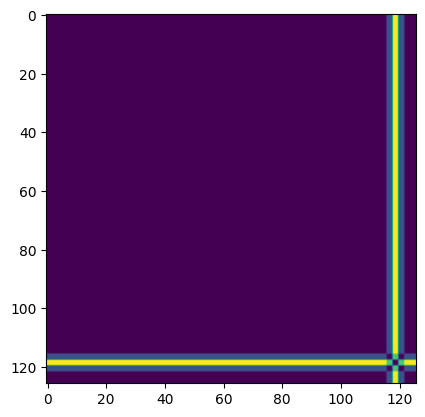

torch.Size([126, 126])
(126, 126)


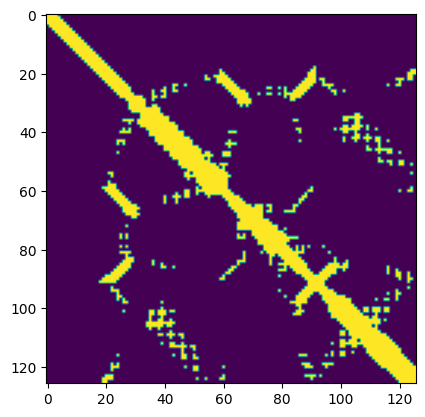

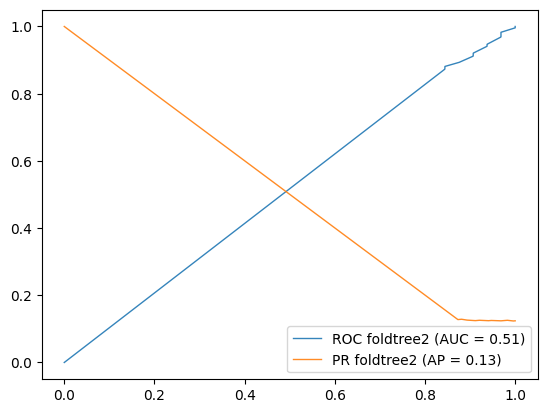

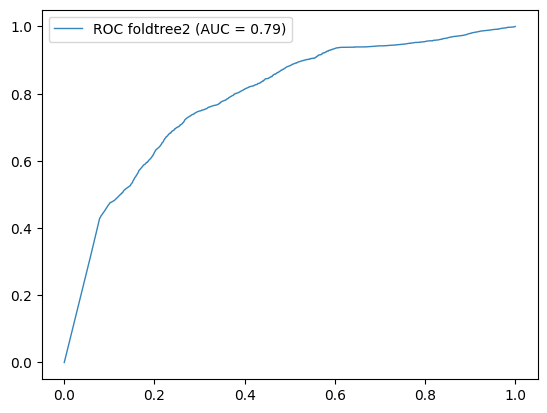

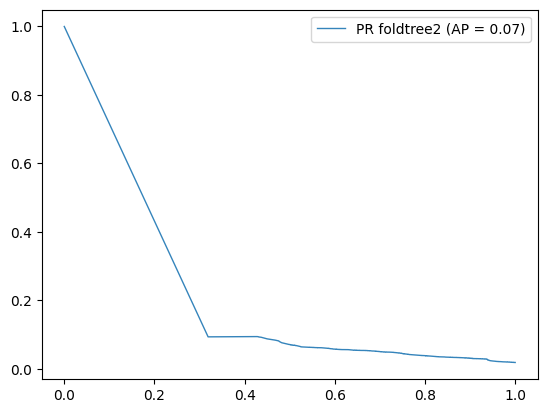

In [27]:
from Bio import PDB
from Bio.PDB import PDBParser
from sklearn.metrics import roc_curve, auc , precision_recall_curve, average_precision_score
from scipy import sparse
import torch_geometric
import losses

def get_alpha_carbon_distance_matrix(pdb_file):
	"""
	Extracts the alpha carbon (Cα) atoms from a PDB structure
	and computes the distance matrix in numpy format.

	Parameters:
	pdb_file (str): Path to the PDB file.

	Returns:
	numpy.ndarray: A matrix of distances between all Cα atoms.
	"""
	# Initialize the PDB parser
	parser = PDBParser(QUIET=True)
	
	# Parse the structure
	structure = parser.get_structure('structure', pdb_file)
	
	# Extract alpha carbon (Cα) atoms
	ca_atoms = []
	for model in structure:
		for chain in model:
			for residue in chain :
				if 'CA' in residue and PDB.is_aa(residue) :
					ca_atoms.append(residue['CA'])
	
	# Get the number of Cα atoms
	num_atoms = len(ca_atoms)
	
	# Initialize the distance matrix
	dist_matrix = np.zeros((num_atoms, num_atoms))
	
	# Compute the distances between all pairs of Cα atoms
	for i, atom_i in enumerate(ca_atoms):
		for j, atom_j in enumerate(ca_atoms):
			if i < j:
				dist_matrix[i, j] = atom_i - atom_j
	dist_matrix += dist_matrix.T
	return dist_matrix

#get aa and contacts
def get_backbone(naa):
	backbone_mat = np.zeros((naa, naa))
	backbone_rev_mat = np.zeros((naa, naa))
	np.fill_diagonal(backbone_mat[1:], 1)
	np.fill_diagonal(backbone_rev_mat[:, 1:], 1)
	return backbone_mat, backbone_rev_mat

def sparse2pairs(sparsemat):
	sparsemat = sparse.find(sparsemat)
	return np.vstack([sparsemat[0],sparsemat[1]])

def decoder_reconstruction2aa( ords , device, verbose = False):
	decoder.eval()
	z = encoder.vector_quantizer.embeddings( ords  ).to('cpu')
	print( z.shape)
	edge_index = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	godnode_index = np.vstack([np.zeros(z.shape[0]), [ i for i in range(z.shape[0]) ] ])
	godnode_rev = np.vstack([ [ i for i in range(z.shape[0]) ] , np.zeros(z.shape[0]) ])
	#generate a backbone for the decoder
	data = HeteroData()
	data['res'].x = z
	backbone, backbone_rev = get_backbone( z.shape[0] )
	backbone = sparse.csr_matrix(backbone)
	backbone_rev = sparse.csr_matrix(backbone_rev)
	backbone = sparse2pairs(backbone)
	backbone_rev = sparse2pairs(backbone_rev)
	positional_encoding = converter.get_positional_encoding( z.shape[0] , 256 )
	data['res'].batch = torch.tensor([0 for i in range(z.shape[0])], dtype=torch.long)
	data['positions'].x = torch.tensor( positional_encoding, dtype=torch.float32)
	data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
	data[ 'res' , 'backbone_rev' , 'res'].edge_index = torch.tensor(backbone_rev, dtype=torch.long)
	#add the godnode
	data['godnode'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder', 'informs', 'res'].edge_index = torch.tensor(godnode_index, dtype=torch.long)
	data['res', 'informs', 'godnode4decoder'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	data['res', 'informs', 'godnode'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	edge_index = edge_index.to( device )
	print( data )
	data = data.to( device )
	allpairs = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	recon_x , edge_probs , zgodnode , foldxout , r, t, angles , r2,t2,angles2= decoder( data , allpairs ) 

	print( edge_probs.shape)
	amino_map = decoder.amino_acid_indices
	revmap_aa = { v:k for k,v in amino_map.items() }
	edge_probs = edge_probs.reshape((z.shape[0], z.shape[0]))
	if verbose == True:
		print( recon_x )
		print( edge_probs )
	aastr = ''.join(revmap_aa[int(idx.item())] for idx in recon_x.argmax(dim=1) )
	return aastr ,edge_probs

postives = []
predictions = []
for ex in range( encoded_df.shape[0] ):
	os.makedirs('tmp', exist_ok=True)
	example = encoded_df.iloc[ex]
	protid = encoded_df.index[ex]
	ords = example['ord']
	print( str(protid))
	AFDB_tools.grab_struct(str(protid) , structfolder='tmp/')
	#show struct
	view_custom_pdb('tmp/' + protid + '.pdb', chain='A')
	#get alpha carbon distmat with biopython
	s = get_alpha_carbon_distance_matrix( 'tmp/' + protid + '.pdb')
	#threshold the distance matrix
	plt.imshow(s)
	plt.colorbar()
	plt.show()
	#these are the embedding indices. shift by 1 to get the hex indices
	ords = torch.tensor([ c-1 if c not in rev_replace_dict_ord else rev_replace_dict_ord[c]-1 for c in ords] , dtype=torch.long)
	print( len(ords))
	ords = ords.to(device)	
	aa, edgeprobs = decoder_reconstruction2aa( ords , device = device, verbose = True)
	print(aa)
	#change range of image to 0-1
	probs = 1-edgeprobs.detach().cpu()
	probs = (probs + probs.T)/2
	plt.imshow(probs) 
	plt.show()
	print( probs.shape)
	print( s.shape)
	#output ROC curve for contact prediction

	pos = np.zeros( s.shape )
	pos[ s < 10] = 1
	pos = pos[ 0:probs.shape[0], 0:probs.shape[1]]
	plt.imshow(pos)
	plt.show()

	postives.append(pos.flatten())
	predictions.append(probs.flatten())

	#flatten the matrices
	pos = pos.flatten()
	probs = probs.flatten()
	fpr, tpr, thresholds = roc_curve(pos, 1-probs)
	roc_auc = auc(fpr, tpr)
	plt.plot(fpr, tpr, lw=1, alpha=0.9, label='ROC foldtree2 (AUC = %0.2f)' % (roc_auc))

	#output precision recall curve
	precision, recall, thresholds = precision_recall_curve(pos, 1-probs)
	average_precision = average_precision_score(pos, 1-probs)
	plt.plot(recall, precision, lw=1, alpha=0.9, label='PR foldtree2 (AP = %0.2f)' % (average_precision))
	plt.legend()
	plt.show()

#output ROC curve for contact prediction
postives = np.concatenate(postives)
predictions = np.concatenate(predictions)
fpr, tpr, thresholds = roc_curve(postives, 1-predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.9, label='ROC foldtree2 (AUC = %0.2f)' % (roc_auc))
plt.legend()
plt.show()

#output precision recall curve
precision, recall, thresholds = precision_recall_curve(postives, 1-predictions)
average_precision = average_precision_score(postives, 1-predictions)
plt.plot(recall, precision, lw=1, alpha=0.9, label='PR foldtree2 (AP = %0.2f)' % (average_precision))
plt.legend()
plt.show()


In [ ]:
# Function to compute Root Mean Square Deviation (RMSD)
def compute_rmsd(coords1, coords2):
    """
    Compute the Root Mean Square Deviation (RMSD) between two sets of coordinates.
    
    Parameters:
    - coords1: Nx3 NumPy array of true coordinates
    - coords2: Nx3 NumPy array of predicted coordinates
    
    Returns:
    - RMSD value
    """
    assert coords1.shape == coords2.shape, "Coordinate arrays must have the same shape"
    
    diff = coords1 - coords2
    rmsd = np.sqrt(np.mean(np.sum(diff**2, axis=1)))
    return rmsd

# Function to compute Local Distance Difference Test (lDDT)
def compute_lddt(true_coords, pred_coords, cutoff=15.0):
    """
    Compute the Local Distance Difference Test (lDDT) score.
    
    Parameters:
    - true_coords: Nx3 NumPy array of true coordinates
    - pred_coords: Nx3 NumPy array of predicted coordinates
    - cutoff: Distance threshold for considering a pair of residues
    
    Returns:
    - lDDT score (0 to 1)
    """
    assert true_coords.shape == pred_coords.shape, "Coordinate arrays must have the same shape"

    num_residues = true_coords.shape[0]
    num_pairs = 0
    num_matching_pairs = 0

    for i in range(num_residues):
        for j in range(i + 1, num_residues):
            true_dist = np.linalg.norm(true_coords[i] - true_coords[j])
            pred_dist = np.linalg.norm(pred_coords[i] - pred_coords[j])

            if true_dist < cutoff:
                num_pairs += 1
                if abs(true_dist - pred_dist) < 0.5 * true_dist:
                    num_matching_pairs += 1

    lddt_score = num_matching_pairs / num_pairs if num_pairs > 0 else 0
    return lddt_score

# Compute RMSD and lDDT
rmsd_value = compute_rmsd(true_coords_from_rt, pred_coords_from_rt)
lddt_value = compute_lddt(true_coords_from_rt, pred_coords_from_rt)

rmsd_value, lddt_value


NameError: name 'true_coords_from_rt' is not defined

In [ ]:

#plot the true and predicted structures
def transform_rt_to_coordinates(rotations, translations):
    """
    Given a list of rotation matrices (R) and translation vectors (t),
    generate the global 3D coordinates of the protein backbone.
    
    Parameters:
    - rotations: List of 3x3 rotation matrices
    - translations: List of 3x1 translation vectors
    
    Returns:
    - coords: Nx3 NumPy array representing the backbone in 3D space
    """
    num_residues = len(rotations)
    assert num_residues == len(translations), "Rotation and translation lists must be the same length"
    
    # Initialize the first coordinate at the origin
    coords = [np.array([0, 0, 0, 1])]  # Homogeneous coordinates

    # Apply transformations iteratively
    current_transform = np.eye(4)  # Identity matrix as starting point

    for R, t in zip(rotations, translations):
        # Construct the transformation matrix (4x4)
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t
        
        # Update the cumulative transformation
        current_transform = current_transform @ T
        
        # Transform the point and store the new coordinates
        new_point = current_transform @ np.array([0, 0, 0, 1])  # Homogeneous coordinates
        coords.append(new_point)

    return np.array(coords)[:, :3]  # Convert back to 3D coordinates (drop the homogeneous coordinate)


def plot_protein_structures_with_thicker_lines(true_coords, pred_coords):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot true structure with thicker lines and transparency
    ax.plot(true_coords[:, 0], true_coords[:, 1], true_coords[:, 2], 
            'bo-', alpha=0.5, label='True Structure', linewidth=3, markersize=6)

    # Plot predicted structure with thicker lines and transparency
    ax.plot(pred_coords[:, 0], pred_coords[:, 1], pred_coords[:, 2], 
            'ro-', alpha=0.5, label='Predicted Structure', linewidth=3, markersize=6)

    # Adjusted arrow size
    arrow_size = 0.15  # Keep small arrows

    # Add arrowheads to indicate backbone direction
    for i in range(len(true_coords) - 1):
        ax.quiver(true_coords[i, 0], true_coords[i, 1], true_coords[i, 2],
                  true_coords[i+1, 0] - true_coords[i, 0], 
                  true_coords[i+1, 1] - true_coords[i, 1], 
                  true_coords[i+1, 2] - true_coords[i, 2],
                  color='blue', alpha=0.5, arrow_length_ratio=arrow_size)

    for i in range(len(pred_coords) - 1):
        ax.quiver(pred_coords[i, 0], pred_coords[i, 1], pred_coords[i, 2],
                  pred_coords[i+1, 0] - pred_coords[i, 0], 
                  pred_coords[i+1, 1] - pred_coords[i, 1], 
                  pred_coords[i+1, 2] - pred_coords[i, 2],
                  color='red', alpha=0.5, arrow_length_ratio=arrow_size)

    # Labels and legend
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('True vs Predicted Protein Backbone Structure with Thicker Lines')
    ax.legend()

    plt.show()

# Plot with thicker lines
plot_protein_structures_with_thicker_lines(true_coords, noisy_pred_coords)


NameError: name 'true_coords' is not defined